In [12]:
import numpy as np  
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import median_abs_deviation as MAD


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Ejercicio 1

### 1) Calcular un intervalo bootstrap de la MAD (median absolute deviation) de la variable pH, justificando la elección y el procedimiento. El intervalo bootstrap construirlo a partir de una submuestra (representativa) de tamaño 70.

In [13]:
data_wine = pd.read_csv('data/winequality-red.csv', sep=';')
data_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [14]:
# Muestra aleatoria
sample = data_wine.sample(n=70, random_state=42)

In [15]:
# Proporción de cada clase en el dataset original
data_wine['quality'].value_counts(normalize=True)

quality
5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: proportion, dtype: float64

In [16]:
# Proporción de cada clase en la muestra
sample['quality'].value_counts(normalize=True)

quality
5    0.485714
6    0.342857
7    0.128571
3    0.014286
8    0.014286
4    0.014286
Name: proportion, dtype: float64

#### La cantidad de observaciones correspondientes a cada clase dentro de la muestra, en proporción, se asemeja bastante al dataset original. Además, existe al menos una observación por categoría (aunque a costa de sobrerrepresentar algunas clases), lo que podría otorgar a la muestra más información.

In [17]:
# Media y desvío de cada variable numérica del dataset original
data_wine.describe().loc[['mean', 'std'], :]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569


In [18]:
# Media y desvío de cada variable numérica de la muestra
sample.describe().loc[['mean', 'std'], :]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
mean,8.185714,0.514786,0.263857,2.364286,0.084229,12.700000,42.057143,0.996638,3.317571,0.665571,10.260714,5.600000
std,1.749475,0.161863,0.184189,1.128265,0.044419,7.313577,29.387903,0.001832,0.145964,0.167017,0.967549,0.840979


#### Si observamos a detalle la estimación de parámetros como la media y el desvío, comparando entre datos originales y muestrales, notamos, una vez más, una semejanza suficientemente decente como para poder considerar a nuestra muestra efectivamente representativa.

In [19]:
# Método Bootstrap
B = 5000
n = len(sample)
bs_mad = np.empty(B)

np.random.seed(42)
for i in range(B):
    bs_sample =  sample.sample(n=n, replace=True)
    bs_mad[i] = MAD(bs_sample['pH'])

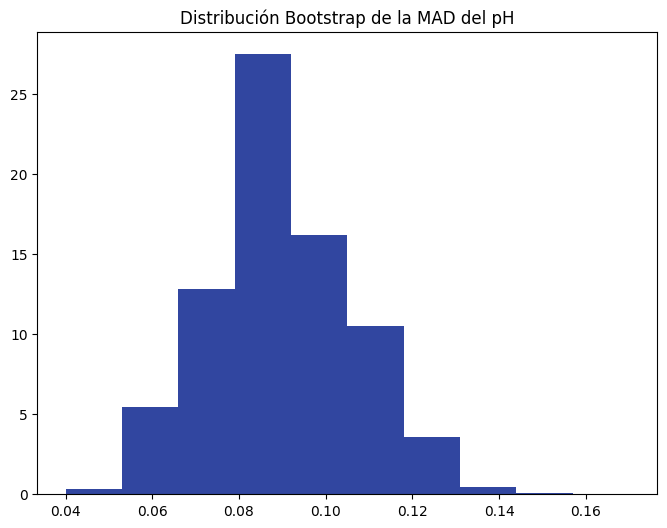

In [20]:
# Gráfico del histograma
plt.figure(figsize=(8,6))
plt.hist(bs_mad, color="#3146a0", density=True)
plt.title('Distribución Bootstrap de la MAD del pH')
plt.show()

#### Analizando el gráfico, podemos afirmar que el histograma de las MAD calculadas para cada muestra bootstrap, que nos sirve como una aproximación o estimación de la función de densidad de probabilidad del estimador de la MAD, tiene una forma suficientemente acampanada como para poder construir el intervalo de confianza de nivel 0,95 de la siguiente manera:

In [21]:
# MAD de los datos de la muestra
mad = MAD(sample['pH'])

# Standard Error
se = np.std(bs_mad, ddof=1)

# Intervalo
bott = mad - 1.96 * se
top = mad + 1.96 * se 

print(f'Intervalo bootstrap para la MAD de nivel 0,95:\n [{bott:.4f} : {top:.4f}]\n')


Intervalo bootstrap para la MAD de nivel 0,95:
 [0.0527 : 0.1173]



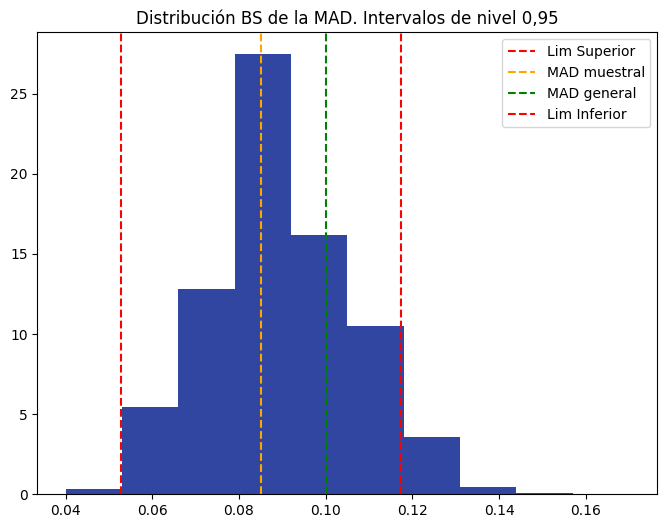

In [22]:
# MAD 'poblacional' (de todo el dataset)
mad_p = MAD(data_wine['pH'])

# Gráfico del histograma y los intervalos calculados, además de la MAD muestral y poblacional
labels = [('Lim Superior', 'red'), ('MAD muestral', 'orange'), ('MAD general', 'green'), ('Lim Inferior', 'red')]

plt.figure(figsize=(8,6))
plt.hist(bs_mad, color="#3146a0", density=True)
plt.title('Distribución BS de la MAD. Intervalos de nivel 0,95')
for label, val in zip(labels, [top, mad, mad_p, bott]):
    plt.axvline(val,
               linestyle='--',
               color=label[1],
               label=label[0])
plt.legend()
plt.show()

In [23]:
# Bias
bias = np.mean(bs_mad) - mad_p

print(f'Error Estándar = {se:.5f}\nSesgo = {bias:.5f}')

Error Estándar = 0.01649
Sesgo = -0.01078


Semilla 101
  Error estándar = 0.01661
  Sesgo = -0.01078

Semilla 22
  Error estándar = 0.01632
  Sesgo = -0.01085

Semilla 11
  Error estándar = 0.01652
  Sesgo = -0.01060

Semilla 36
  Error estándar = 0.01672
  Sesgo = -0.01053



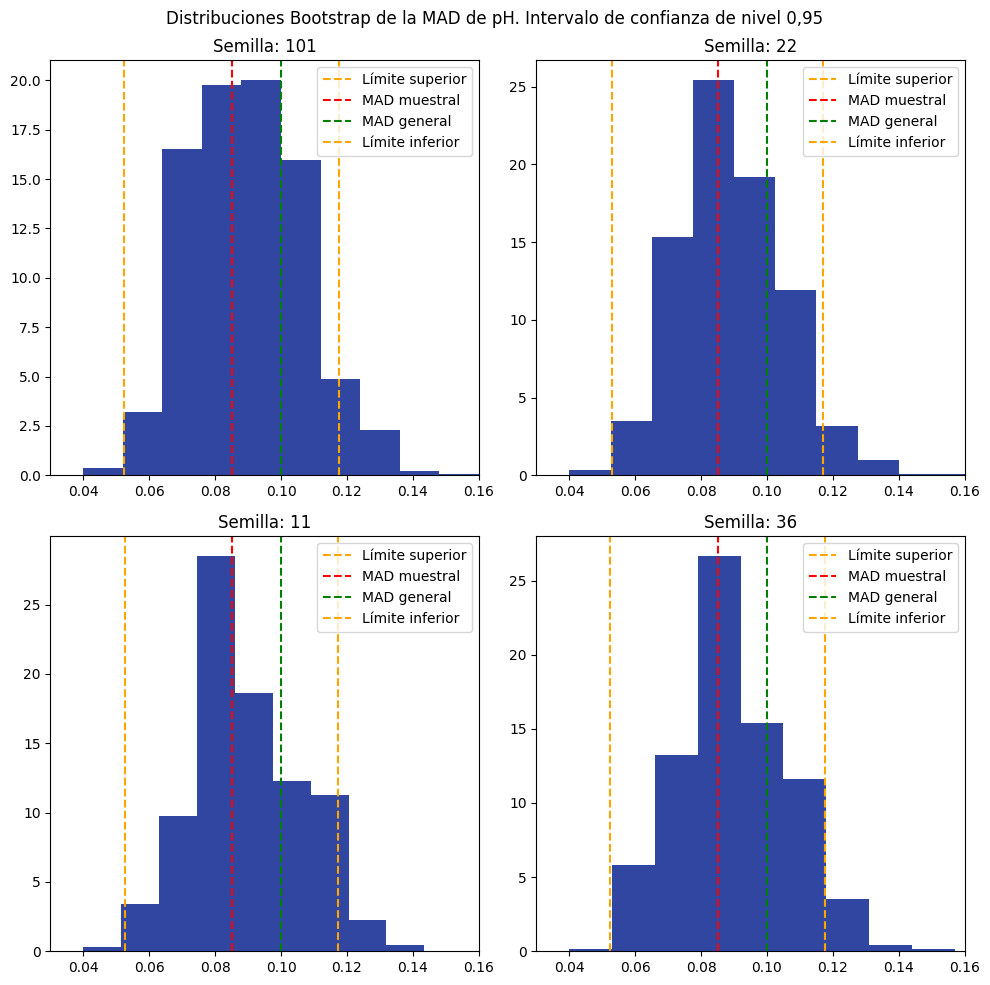

In [24]:
seeds = [101, 22, 11, 36]
B = 5000
n = len(sample)
mad = MAD(sample['pH'])
mad_p = MAD(data_wine['pH'])

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
fig.suptitle('Distribuciones Bootstrap de la MAD de pH. Intervalo de confianza de nivel 0,95')


for seed, ax in zip(seeds, axes):
    bs_mad = np.empty(B)
    np.random.seed(seed)
    for i in range(B):
        bs_sample =  sample.sample(n=n, replace=True)
        bs_mad[i] = MAD(bs_sample['pH'])
    bias = np.mean(bs_mad) - mad_p
    se = np.std(bs_mad, ddof=1)
    intervalo = [mad - 1.96 * se, mad + 1.96 * se]
    print(f'Semilla {seed}\n  Error estándar = {se:.5f}\n  Sesgo = {bias:.5f}\n')
    ax.hist(bs_mad, color="#3146a0", density=True)
    ax.axvline(intervalo[1],
               linestyle='--',
               color='orange',
               label='Límite superior')
    ax.axvline(mad,
               linestyle='--',
               color='red',
               label='MAD muestral')
    ax.axvline(mad_p,
               linestyle='--',
               color='green',
               label='MAD general')
    ax.axvline(intervalo[0],
               linestyle='--',
               color='orange',
               label='Límite inferior')
    ax.set_title(f'Semilla: {seed}')
    ax.set_xlim(0.03, 0.16)
    ax.legend()    
plt.tight_layout()
plt.show()


# Ejercicio 2

In [25]:
df = pd.read_csv("data/tabla_nutricional.csv", sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alimento              53 non-null     object 
 1   Cantidad (gr/ml)      53 non-null     float64
 2   HC (gr)               39 non-null     float64
 3   Proteinas (gr)        44 non-null     float64
 4   Grasas (gr)           31 non-null     float64
 5   Na (mg)               51 non-null     float64
 6   Ca (mg)               49 non-null     float64
 7   Fe (mg)               42 non-null     float64
 8   Azucares Libres (gr)  7 non-null      float64
 9   AGS (gr)              29 non-null     float64
 10  AGNI (gr)             26 non-null     float64
 11  AG p (gr)             27 non-null     float64
 12  Fibra (gr)            23 non-null     float64
dtypes: float64(12), object(1)
memory usage: 5.5+ KB


### A) Leer los datos de la tabla. Completar las celdas faltantes con ceros. Poner todos los datos en la misma unidad.

In [26]:
#Reemplazo de ceros

df = df.fillna(0)

#Pasaje de miligramos a gramos
for i in ['Na (mg)', 'Ca (mg)', 'Fe (mg)']:
    df[i] = df[i] / 1000

#Renombramos las columnas
df.rename(columns = {
    'Na (mg)': 'Na (gr)', 
    'Ca (mg)': 'Ca (gr)', 
    'Fe (mg)': 'Fe (gr)',
    }, inplace = True)

df.head()

,Alimento,Cantidad (gr/ml),HC (gr),Proteinas (gr),Grasas (gr),Na (gr),Ca (gr),Fe (gr),Azucares Libres (gr),AGS (gr),AGNI (gr),AG p (gr),Fibra (gr)
0,Leche fluida entera,270.00,12.42,8.37,7.83,0.15390,0.28350,0.18900,0.0,4.99,2.19,0.52,0.0
1,Leche entera en polvo,11.00,4.51,2.84,2.73,0.04444,0.09900,0.00006,0.0,1.62,0.77,0.06,0.0
2,Yogurt,19.00,2.45,0.51,0.49,0.00799,0.01767,0.00500,0.0,0.32,0.14,14.00,0.0
3,Queso crema,1.66,0.06,0.10,0.37,0.00123,0.00093,0.00000,0.0,0.36,0.11,0.01,0.0
4,Queso cuartirolo,3.66,0.06,0.77,0.80,0.02084,0.01654,0.00000,0.0,0.76,0.21,0.02,0.0


### B) Realizar un Analisis en Componentes Principales (ACP), tomando el valor nutricional de cada alimento por gramo. ¿Cuantas componentes principales eligirıa para reducir la dimension del conjunto de datos original?

In [27]:
ss = StandardScaler()
X = df.drop('Alimento', axis=1)
y = df['Alimento']

X_scaled = ss.fit_transform(X)
dfStandard = pd.DataFrame(X_scaled, columns = X.columns)
dfStandard.head()

,Cantidad (gr/ml),HC (gr),Proteinas (gr),Grasas (gr),Na (gr),Ca (gr),Fe (gr),Azucares Libres (gr),AGS (gr),AGNI (gr),AG p (gr),Fibra (gr)
0,4.308463,-0.094551,0.247462,1.178281,-0.042065,6.610697,7.200873,-0.182494,-0.122562,-0.116989,-0.256264,-0.396011
1,-0.420637,-0.176072,-0.183333,0.173900,-0.153091,2.092320,-0.160371,-0.182494,-0.147087,-0.205736,-0.264520,-0.396011
2,-0.274565,-0.197302,-0.364844,-0.267241,-0.190063,0.100561,0.032095,-0.182494,-0.156548,-0.245109,-0.014334,-0.396011
3,-0.591177,-0.221934,-0.396784,-0.290873,-0.196919,-0.309399,-0.162709,-0.182494,-0.156257,-0.246984,-0.265417,-0.396011
4,-0.554659,-0.221934,-0.344590,-0.206190,-0.177029,0.072887,-0.162709,-0.182494,-0.153346,-0.240734,-0.265237,-0.396011


#### Analizamos la acumulación de varianza lograda según la cantidad de variables contempladas

In [28]:
varianza = { 'Varianza' : [], 'Acumulada' : [] }
lista_varianza = []
lista_varianza_acumulada = []
idx = []

for i in range(1,X_scaled.shape[1] + 1):
    pca_var= PCA(n_components=i)
    pca_var.fit(dfStandard)
    varianza['Varianza'].append(np.round(pca_var.explained_variance_ratio_.tolist()[i-1],5))
    varianza['Acumulada'].append(np.round(pca_var.explained_variance_ratio_.cumsum().tolist()[i-1],5))
    idx.append(i)

tabla = pd.DataFrame(varianza, index=idx)
tabla

,Varianza,Acumulada
1,0.22456,0.22456
2,0.15404,0.37860
3,0.12959,0.50819
4,0.11193,0.62013
5,0.08731,0.70743
6,0.08200,0.78943
7,0.07936,0.86879
8,0.06960,0.93839
9,0.03459,0.97298
10,0.01721,0.99018


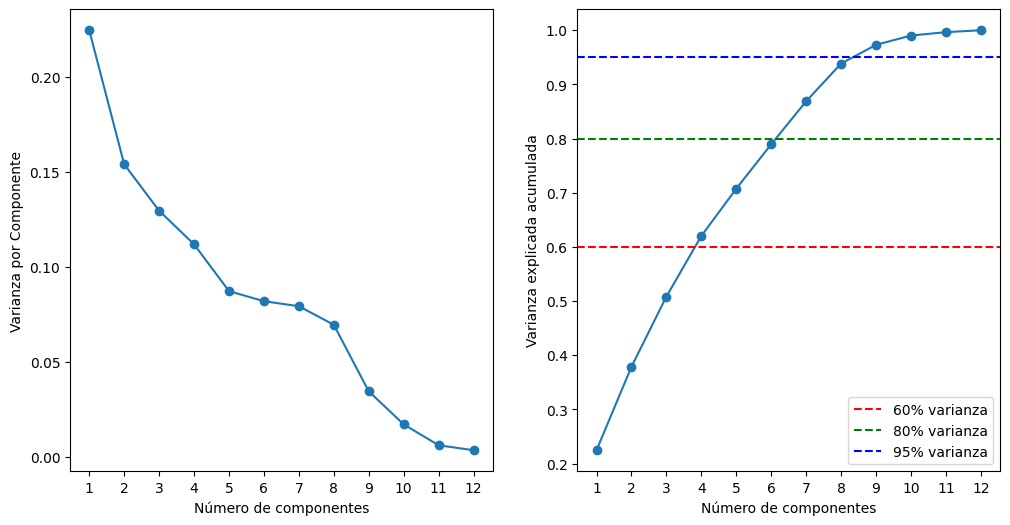

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.plot(range(1, len(varianza['Varianza'])+1),
         varianza['Varianza'], marker='o')
ax1.set_xticks(range(1, len(varianza['Varianza']) + 1))
ax1.set_xlabel('Número de componentes')
ax1.set_ylabel('Varianza por Componente')

ax2.plot(range(1, len(varianza['Varianza'])+1),
         varianza['Acumulada'], marker='o')
ax2.set_xticks(range(1, len(varianza['Varianza']) + 1))
ax2.axhline(y=0.60, color='r', linestyle='--', label='60% varianza')
ax2.axhline(y=0.80, color='g', linestyle='--', label='80% varianza')
ax2.axhline(y=0.95, color='b', linestyle='--', label='95% varianza')
ax2.set_xlabel('Número de componentes')
ax2.set_ylabel('Varianza explicada acumulada')

plt.legend()
plt.show()

#### Analizando los gráficos, logramos identificar tres momentos donde se percibe la mayor caída en la cantidad de varianza explicada. Primordialmente, tenemos una gran disminución representada entre los componentes 1 y 2. Notamos que la caída de varianza explicada es abrupta con relación a los demás puntos. Sin embargo, no logra ser una cantidad de variables óptima a seleccionar por su baja representación acumulada. Luego, entre las variables 4 y 5. Pese a ello, la varianza acumulada en esa cantidad de componentes no logra ser de un valor adecuado a considerar. Debido a eso, identificamos que se produce una segunda caída en la cantidad de varianza explicada para la cantidad de componentes 8 y 9. 

#### Por lo visto en clase, y como se indica en la bibliografía de la materia ("An Introduction to Statistical Learning: With application in Python"), priorizamos la cantidad de varianza acumulada superior al 80% e inferior al 95% garantizando una explicación de varianza alta evitando el sobreajuste. Sin embargo, la representación que será posible realizar en 2 y 3 dimensiones, alcanza una explicación relativamente baja para nuestro set de datos implementando solo 2 y 3 componentes principales respectivamente. 

### C) Graficar cada alimento como un punto en ejes coordenados de un nuevo espacio 

In [30]:
#Aplicación de PCA con 8 componentes principales
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)

In [31]:
alimentos = y.unique().tolist()
alimentos.sort()

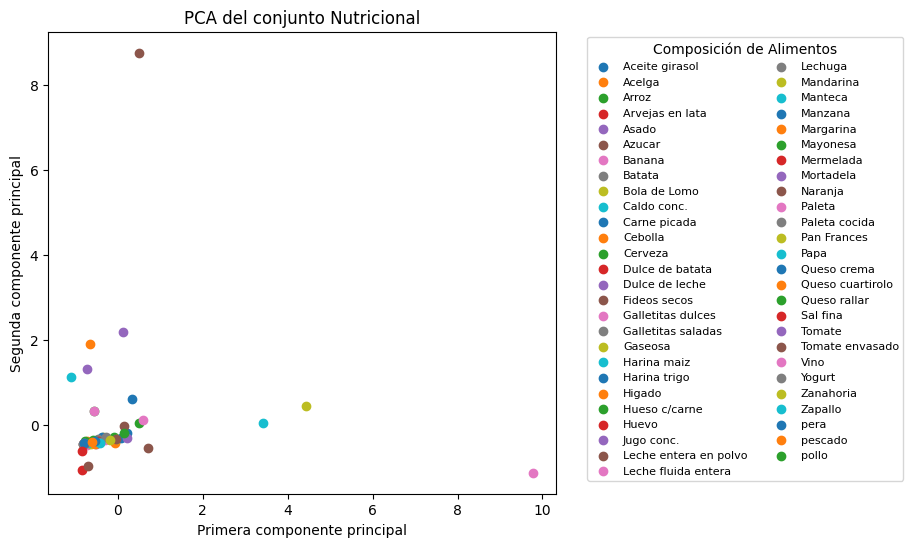

In [32]:
plt.figure(figsize=(30,6))
plt.axes().set_aspect('equal')

for i in range(len(alimentos)):
    plt.scatter(X_pca[y == alimentos[i], 0], X_pca[y == alimentos[i], 1], label=alimentos[i])
plt.xlabel('Primera componente principal')
plt.ylabel('Segunda componente principal')
plt.legend(title='Composición de Alimentos', 
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    ncol=2,
    fontsize=8)
plt.title('PCA del conjunto Nutricional')
plt.show()

In [33]:
df_plot = pd.DataFrame(X_pca[:, :3], columns=['CP1', 'CP2', 'CP3'])
df_plot['Alimento'] = y  

fig = px.scatter_3d(df_plot, x='CP1', y='CP2', z='CP3', color='Alimento')
fig.update_layout(title='Visualización 3D del PCA nutricional')
fig.show()

C:\Users\Estudio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotly\express\_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


### D ) En el gráfico realizado en el  ́ıtem anterior, analizar si se visualizan agrupamientos de los alimentos.

#### Visualizando la gráfica realizada anteriormente, no existen agrupamientos marcados que puedan ser determinados por las primeras 3 componentes principales. De acuerdo con la fundamentación realizada en la elección de los componentes, el análisis de un gráfico de componentes principales que explique menos del 60% de la varianza carece de fiabilidad. 

# Ejericio 3

In [34]:
df = pd.read_csv("data/planets.csv")
df.head()

,mass,period,eccen
0,0.120,4.950,0.00
1,0.197,3.971,0.00
2,0.210,44.280,0.34
3,0.220,75.800,0.28
4,0.230,6.403,0.08


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mass    101 non-null    float64
 1   period  101 non-null    float64
 2   eccen   101 non-null    float64
dtypes: float64(3)
memory usage: 2.5 KB


### A) Cuando las variables estan en escalas muy diferentes, se necesitara usar alguna forma de estandarizacion. Realizar un grafico tridimensional usando las observaciones escaladas.

In [36]:
ss = StandardScaler()
df_standard = pd.DataFrame(ss.fit_transform(df), columns=df.columns)

In [37]:
fig = px.scatter_3d(df_standard, x='mass', y='period', z='eccen')
fig.update_layout(title='Visualización 3D de las observaciones escaladas')
fig.show()

### B) Aplicar, a los datos escalados, el comando kmeans usando 4 centroides (de manera aleatoria) y obtener el valor mınimo de la funcion objetivo. Inspeccionar visualmente los agrupamientos generados.

In [38]:
kmeans = KMeans(n_clusters=4, init = "random", n_init=10)
kmeans.fit(df_standard)
centroides=kmeans.cluster_centers_
etiquetas=kmeans.labels_
print(f"El valor mínimo de la función objetivo es: {kmeans.inertia_}")

El valor mínimo de la función objetivo es: 110.92450795892978


In [39]:
fig = px.scatter_3d(df_standard, x='mass', y='period', z='eccen', color=etiquetas, title='Visualización 3D de los exoplanetas estandarizados')
fig.add_trace(go.Scatter3d(
    x=centroides[:, 0],
    y=centroides[:, 1],
    z=centroides[:, 2],
    mode='markers',
    marker=dict(size=8, color='red', symbol='diamond'),
    name='Centroides'
))
fig.show()

### C) Repetir el ıtem anterior varias veces y comparar.

In [47]:
np.random.seed(0)
seeds = list(np.random.randint(0, 100, size = 4))
centroides_rep = []
etiquetas_rep = []
for seed in seeds:
    kmeans = KMeans(n_clusters=4, init = "random", n_init=10, random_state=seed)
    kmeans.fit(df_standard)
    centroides_rep.append(kmeans.cluster_centers_)
    etiquetas_rep.append(kmeans.labels_)
    print(f"\nPara semilla = {seed}, el valor mínimo de la función objetivo es: {kmeans.inertia_:.4f}")


Para semilla = 44, el valor mínimo de la función objetivo es: 110.8569

Para semilla = 47, el valor mínimo de la función objetivo es: 110.6429

Para semilla = 64, el valor mínimo de la función objetivo es: 110.3288

Para semilla = 67, el valor mínimo de la función objetivo es: 110.6061


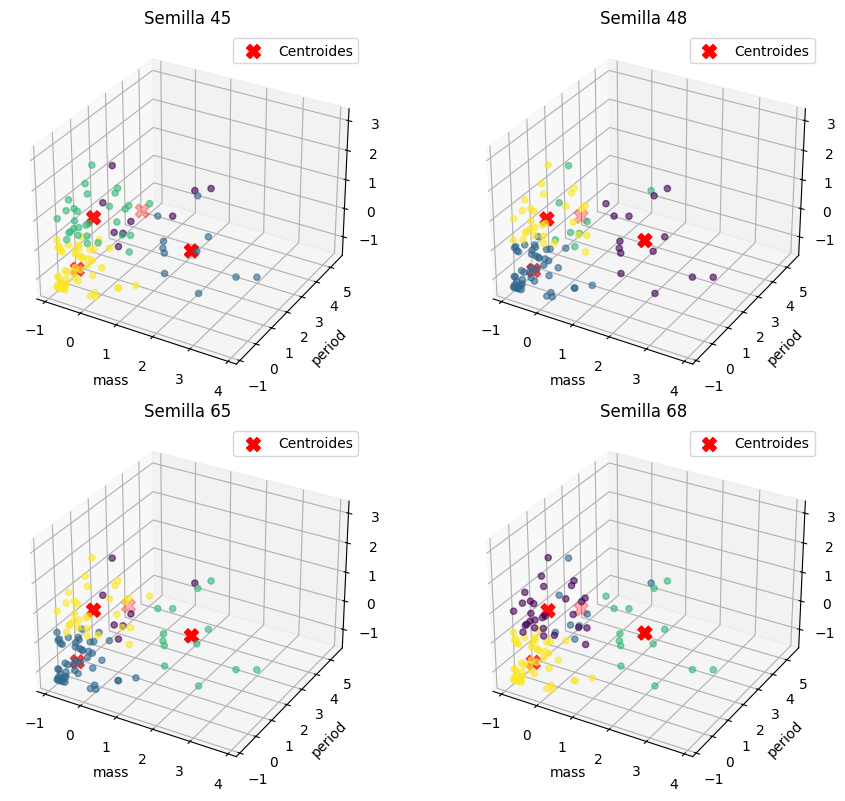

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(10,8), subplot_kw={'projection': '3d'})

axes = axes.flatten()

for idx, i in enumerate(seeds):
    ax = axes[idx]
    
    ax.scatter(df_standard.iloc[:,0], df_standard.iloc[:,1], df_standard.iloc[:,2],
               c=etiquetas_rep[idx], cmap='viridis', alpha=0.6)
    
    ax.scatter(centroides_rep[idx][:,0], centroides_rep[idx][:,1], centroides_rep[idx][:,2],
               c='red', marker='X', s=100, label='Centroides')
    
    ax.set_title(f'Semilla {i+1}')
    ax.set_xlabel(df_standard.columns[0])
    ax.set_ylabel(df_standard.columns[1])
    ax.legend()

plt.tight_layout()
plt.show()

### D) Ejecutar el metodo K-medias eligiendo los centroides a partir de algun criterio.

#### Evaluamos cúal de los 3 criterios minimiza mejor la función objetivo

In [51]:
k_values = range(2, 11)

idx = []
resultados = {"random": [], "k-means++": [], "propios": []}


for k in k_values:
    # Método random
    km_random = KMeans(n_clusters=k, init="random", n_init=10, random_state=42)
    km_random.fit(df_standard)
    resultados["random"].append(np.trunc(km_random.inertia_ * 10000) / 10000)
    
    # Método k-means++
    km_plus = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    km_plus.fit(df_standard)
    resultados["k-means++"].append(np.trunc(km_plus.inertia_ * 10000) / 10000)
    
    # Método con centroides propios (ejemplo: muestreo de k filas)
    seleccion_centroides = df_standard.sample(n=k, random_state=42).values
    km_propios = KMeans(n_clusters=k, init=seleccion_centroides, n_init=1, random_state=42)
    km_propios.fit(df_standard)
    resultados["propios"].append(np.trunc(km_propios.inertia_ * 10000) / 10000)

    idx.append(k)

idx.append("Promedio")
resultados["random"].append(np.array(resultados["random"]).mean())
resultados["k-means++"].append(np.array(resultados["k-means++"]).mean())
resultados["propios"].append(np.array(resultados["propios"]).mean())

tabla = pd.DataFrame(resultados, index=idx)
tabla


,random,k-means++,propios
2,194.592600,194.592600,194.867700
3,145.014300,145.014300,153.617800
4,110.606100,110.379100,110.999000
5,92.012900,92.012900,93.293100
6,78.357000,79.805000,85.291600
7,64.909600,64.531800,77.701700
8,57.997100,57.641200,68.401200
9,52.406500,51.974000,65.441900
10,48.593600,46.184600,60.900000
Promedio,93.832189,93.570611,101.168222


#### Seleccionamos al método k-means++ ya que es el que minimiza mejor la función objetivo en promedio.

### F ) Utilizar el metodo del codo para identificar la cantidad de clusters en cada uno de los metodos. ¿Cuantos grupos le sugiere?

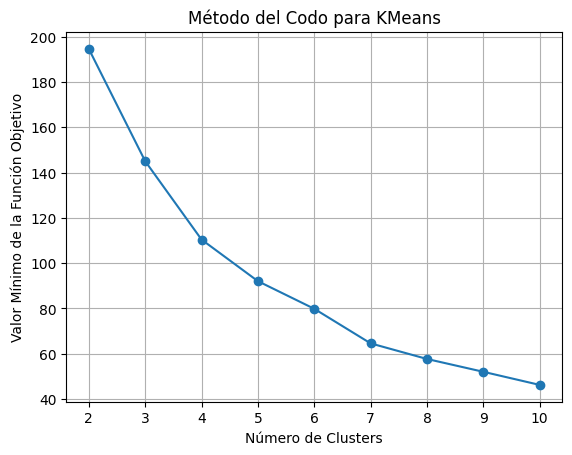

In [52]:
#Seleccionamos para analizar el método k_means++

tabla.drop("Promedio", axis=0, inplace=True)


plt.plot(k_values, tabla["k-means++"], marker='o')
plt.grid(True)
plt.title("Método del Codo para KMeans")
plt.xticks(k_values)
plt.xlabel("Número de Clusters")
plt.ylabel("Valor Mínimo de la Función Objetivo")
plt.show()

#### Luego de implementar el método del codo, el gráfico denota una caída sostenida del valor mínimo de la función objetivo, como es de esperarse. Sin embargo, no se logra visualizar un quiebre contuntende con posterior planicie que permita identificar un Número de Clusters acertado. 

#### Procedemos a implementar también el método Silhouette a continuación, para poder obtener mayor información y tomar una decisión.

 ### G) Utilizar el metodo Silhouette para identificar la cantidad de clusters en cada uno de los metodos. ¿Cuantos grupos le sugiere?

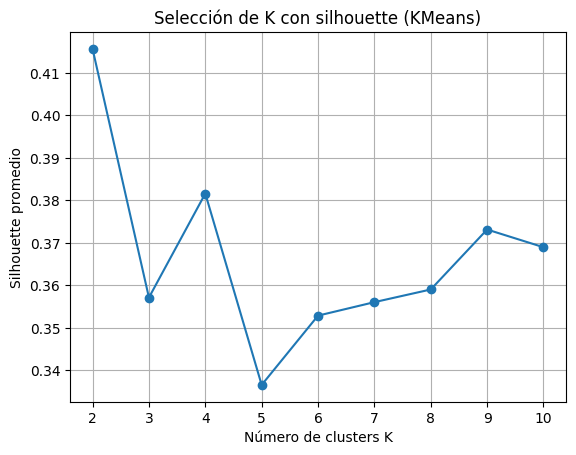

In [53]:
silh_score = []

for k in range(2,11):
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    etiqueta_sil = kmeans.fit_predict(df_standard)
    score = silhouette_score(df_standard, etiqueta_sil)
    silh_score.append(score)

plt.plot(range(2, 11), silh_score, marker='o')
plt.xlabel("Número de clusters K")
plt.ylabel("Silhouette promedio")
plt.title("Selección de K con silhouette (KMeans)")
plt.grid(True)
plt.show()

#### Silhouette nos indica una Cohesión positiva para un Número de Cluster igual a 2, 4 y 9. 

### H) Concluir

#### Con k=2 se obtendra una separación clara y compacta sin tener en cuenta posibles subgrupos.

#### Trabajando con k=4 se mejora la estructura interna de separación y su explicación en la variabilidad interna, además no sobreajustamos demasiado el modelo ni agregamos complejidad.

#### Por último, El tercer valor más alto conseguido es para k=9. Sin embargo, este valor es descartado por aportar complejidad innecesaria  con información dificil de interpretar y comunicar en sus gráficos.

#### Para respaldar nuestra conclusión, procedemos a graficar las elecciones y descarte frente a la cantidad de Clusters

El valor mínimo de la función objetivo es: 194.59268866325758


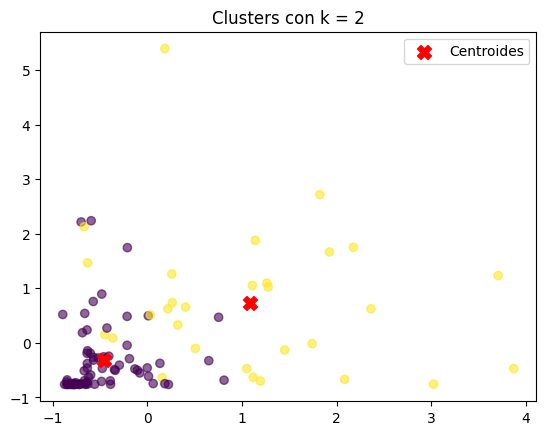

In [54]:
# Análisis con k=2 en 2D

kmeans_2 = KMeans(n_clusters=2, init = "k-means++", n_init=10, random_state=42)
kmeans_2.fit(df_standard)
centroides_2=kmeans_2.cluster_centers_
etiquetas_2=kmeans_2.labels_
print(f"El valor mínimo de la función objetivo es: {kmeans_2.inertia_}")

plt.figure()
plt.scatter(df_standard['mass'], df_standard['period'], c=etiquetas_2, cmap='viridis', alpha=0.6)
plt.scatter(centroides_2[:, 0], centroides_2[:, 1], c='red', marker='X', s=100, label='Centroides')
plt.title("Clusters con k = 2") 
plt.legend()  
plt.show()

In [55]:
# Análisis con k=2 en 3D

fig = px.scatter_3d(df_standard, x='mass', y='period', z='eccen',color=etiquetas_2,title='Visualización 3D con k=2')
fig.add_trace(go.Scatter3d(
    x=centroides_2[:, 0],
    y=centroides_2[:, 1],
    z=centroides_2[:, 2],
    mode='markers',
    marker=dict(size=8, color='red', symbol='diamond'),
    name='Centroides'
))
fig.show()

El valor mínimo de la función objetivo es: 110.3791161269912


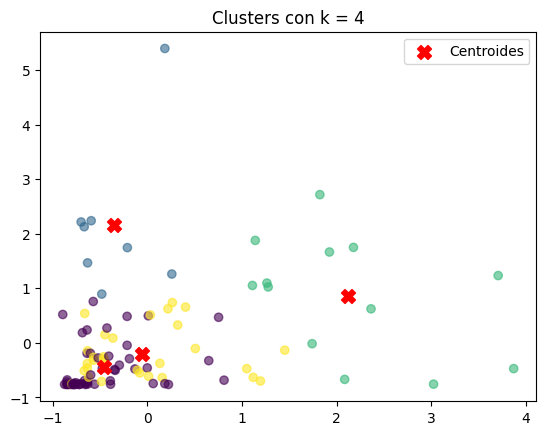

In [56]:
# Análisis con k=4 en 2D


kmeans_4 = KMeans(n_clusters=4, init = "k-means++", n_init=10, random_state=42)
kmeans_4.fit(df_standard)
centroides_4=kmeans_4.cluster_centers_
etiquetas_4=kmeans_4.labels_
print(f"El valor mínimo de la función objetivo es: {kmeans_4.inertia_}")

plt.figure()
plt.scatter(df_standard['mass'], df_standard['period'], c=etiquetas_4, cmap='viridis', alpha=0.6)
plt.scatter(centroides_4[:, 0], centroides_4[:, 1], c='red', marker='X', s=100, label='Centroides')
plt.title("Clusters con k = 4")   
plt.legend()
plt.show()

In [57]:
# Análisis con k=4 en 3D

fig = px.scatter_3d(df_standard, x='mass', y='period', z='eccen',
                    color=etiquetas_4,title='Visualización 3D con k=4')
fig.add_trace(go.Scatter3d(
    x=centroides_4[:, 0],
    y=centroides_4[:, 1],
    z=centroides_4[:, 2],
    mode='markers',
    marker=dict(size=8, color='red', symbol='diamond'),
    name='Centroides'
))
fig.show()

El valor mínimo de la función objetivo es: 51.9740819450886


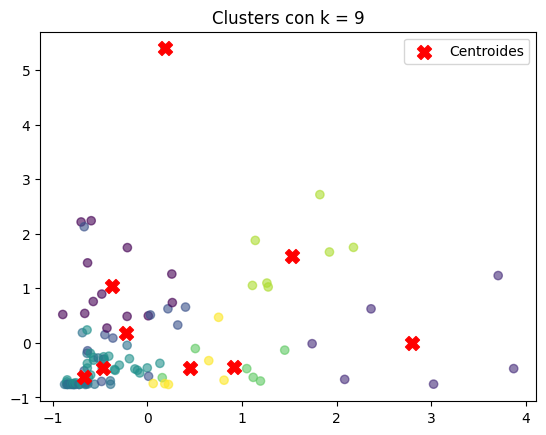

In [58]:
# Análisis con k=9 en 2D


kmeans_9 = KMeans(n_clusters=9, init = "k-means++", n_init=10, random_state=42)
kmeans_9.fit(df_standard)
centroides_9=kmeans_9.cluster_centers_
etiquetas_9=kmeans_9.labels_
print(f"El valor mínimo de la función objetivo es: {kmeans_9.inertia_}")
plt.figure()
plt.scatter(df_standard['mass'], df_standard['period'], c=etiquetas_9, cmap='viridis', alpha=0.6)
plt.scatter(centroides_9[:, 0], centroides_9[:, 1], c='red', marker='X', s=100, label='Centroides')
plt.title("Clusters con k = 9")
plt.legend()
plt.show()

In [59]:
# Análisis con k=9 en 3D


fig = px.scatter_3d(df_standard, x='mass', y='period', z='eccen',color=etiquetas_9,title='Visualización 3D con k=9')
fig.add_trace(go.Scatter3d(
    x=centroides_9[:, 0],
    y=centroides_9[:, 1],
    z=centroides_9[:, 2],
    mode='markers',
    marker=dict(size=8, color='red', symbol='diamond'),
    name='Centroides'
))
fig.show()